In [5]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Exploration
**Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.**

In [6]:
#load data
case = spark.read.csv('case.csv', header = True)
dept = spark.read.csv('dept.csv', header = True)
source = spark.read.csv('source.csv', header = True)

case = (case.withColumn('case_late', case.case_late.cast('boolean'))
            .withColumn('case_status', case.case_status.cast('boolean'))
            .withColumn('num_days_late', case.num_days_late.cast('float'))
            .withColumn('SLA_days', case.SLA_days.cast('float'))
            .withColumn('case_opened_date', F.to_timestamp(case.case_opened_date, 'M/d/yy H:mm'))
            .withColumn('case_closed_date', F.to_timestamp(case.case_closed_date, 'M/d/yy H:mm'))
            .withColumn('SLA_due_date', F.to_timestamp(case.SLA_due_date, 'M/mm/yy H:mm'))
       )
dept = dept.withColumn('dept_subject_to_SLA', dept.dept_subject_to_SLA.cast('boolean'))

df = case.join(source, on = 'source_id', how = 'inner').join(dept, on = 'dept_division')


In [7]:
df.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- case_id: string (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- SLA_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: float (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: float (nullable = true)
 |-- case_status: boolean (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)
 |-- source_username: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: boolean (nullable = true)



- How many different cases are there, by department?

In [10]:
df.groupBy('dept_division').agg(F.expr('count(distinct case_id)')).show(5)

+--------------------+--------------+
|       dept_division|count(case_id)|
+--------------------+--------------+
|       Miscellaneous|         45119|
|         Solid Waste|           813|
|    Field Operations|        116897|
|    Waste Collection|        215087|
|             Streets|         38500|
|          District 7|             2|
|Code Enforcement ...|          2189|
|         District 10|             2|
|              Vector|           538|
|        Reservations|             2|
|   Dangerous Premise|         15476|
|     311 Call Center|          2848|
|               Brush|         18208|
|Dangerous Premise...|            36|
|Traffic Engineeri...|          4333|
|Code Enforcement ...|           198|
|          District 2|             3|
|             Signals|         20695|
|Engineering Division|          1374|
|Director's Office...|           515|
+--------------------+--------------+
only showing top 20 rows



- Does the percentage of cases that are late vary by department?

In [ ]:
late_depts = df.groupBy('dept_division').pivot('case_late').count().toPandas()

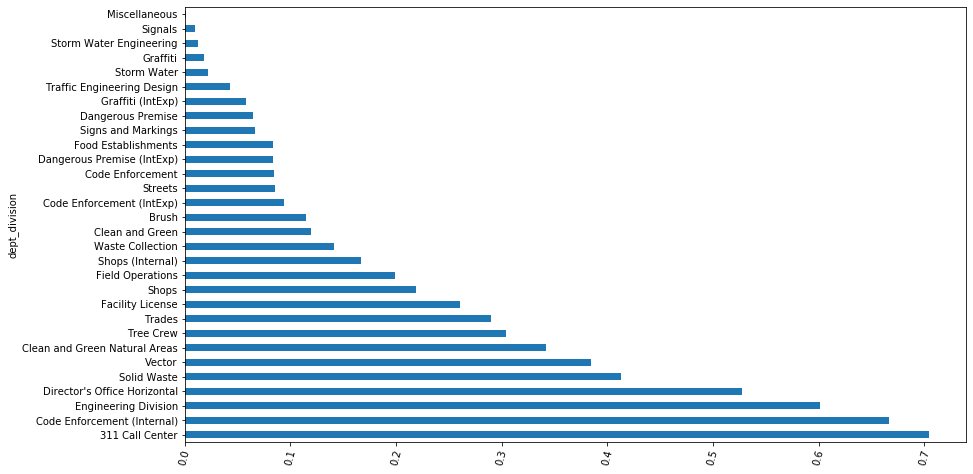

In [59]:
late_depts.dropna(inplace = True)
late_depts['pct_late'] = late_depts.true / (late_depts.false + late_depts.true)
plt.figure(figsize=(14,8))
late_depts.set_index('dept_division').sort_values(by = 'pct_late',ascending = False).pct_late.plot.barh()
plt.xticks(rotation = 75)
plt.show()

- On average, how late are the late cases by department?

<Figure size 1008x576 with 0 Axes>

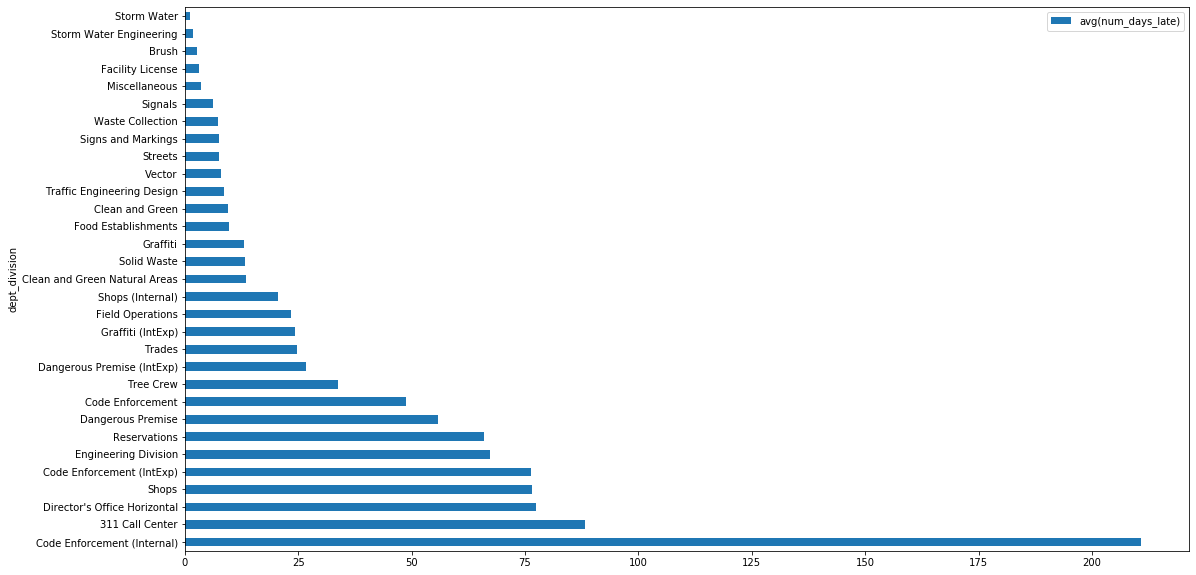

In [58]:
late_days_by_dept = df.where(df.case_late).groupBy('dept_division').agg(F.mean('num_days_late')).sort(F.desc('avg(num_days_late)')).toPandas()
plt.figure(figsize=(14,8))
late_days_by_dept.set_index('dept_division').plot.barh()
plt.gcf().set_size_inches(18, 10)


- What is the service type that is the most late? Just for Parks & Rec?

In [67]:
late_type = df.groupBy('service_request_type').pivot('case_late').count().toPandas()

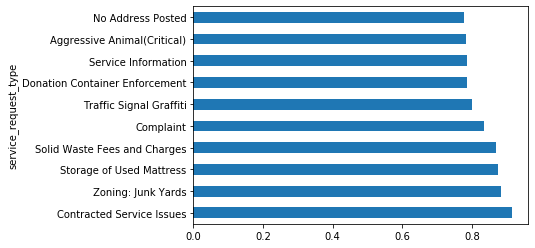

In [70]:
late_type.set_index('service_request_type', inplace=True)
late_type['late_pct'] = late_type.true / (late_type.false +late_type.true)
late_type.sort_values('late_pct', ascending=False).head(10).late_pct.plot.barh()

In [78]:
#for P&R
park_rec_late_type = df.where(df.standardized_dept_name == 'Parks & Recreation').groupBy('service_request_type').pivot('case_late').count().toPandas()

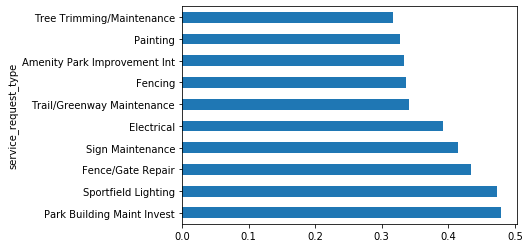

In [79]:
park_rec_late_type.set_index('service_request_type', inplace=True)
park_rec_late_type['late_pct'] = park_rec_late_type.true / (late_type.false +late_type.true)
park_rec_late_type.sort_values('late_pct', ascending=False).head(10).late_pct.plot.barh()

- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [84]:
df.where(df.standardized_dept_name == 'DSD/Code Enforcement').groupBy('service_request_type').count().sort(F.desc('count')).show()

+--------------------+-----+
|service_request_type|count|
+--------------------+-----+
|Overgrown Yard/Trash|66403|
|        Bandit Signs|32968|
|Front Or Side Yar...|28920|
|Junk Vehicle On P...|21649|
|Alley-Way Mainten...|20293|
|Right Of Way/Side...|17836|
|Vacant Lot/Overgr...| 9497|
|Minimum Housing-O...| 8617|
|Graffiti: Private...| 8525|
|Minimum Housing-T...| 8104|
|Dang. Premises/CL...| 8004|
|"Vacant Lot-Priva...| 7875|
|    Brush Violations| 7530|
|    Permits Building| 6950|
|Vacant House Over...| 6278|
|  Graffiti: Building| 4572|
|Low Hanging Limbs...| 4107|
|Graffiti Public P...| 4104|
|CPS Energy Wood P...| 3501|
|Zoning Business i...| 2773|
+--------------------+-----+
only showing top 20 rows



- Does whether or not its a weekend matter for when a case is opened/closed?

In [101]:
day_of_week_open = df.select(F.dayofweek('case_opened_date').alias('weekday'))
opened_by_weekday = day_of_week_open.where(~F.isnull('weekday')).groupBy('weekday').count().toPandas()

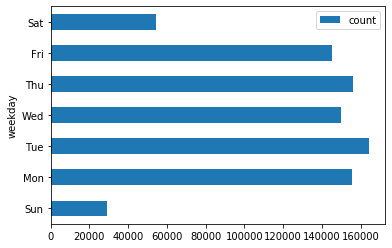

In [113]:
opened_by_weekday.set_index('weekday').sort_index().plot.barh()
plt.yticks(ticks = [0,1,2,3,4,5,6],labels = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
plt.show()

In [116]:
day_of_week_close = df.select(F.dayofweek('case_closed_date').alias('weekday'))
closed_by_weekday = day_of_week_close.where(~F.isnull('weekday')).groupBy('weekday').count().toPandas()

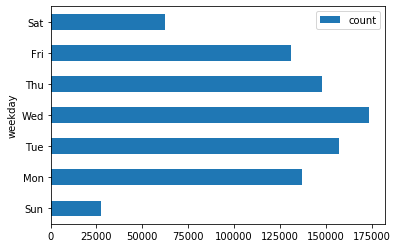

In [117]:
closed_by_weekday.set_index('weekday').sort_index().plot.barh()
plt.yticks(ticks = [0,1,2,3,4,5,6],labels = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
plt.show()

- On average, how many cases are opened a day for the Customer Service department?

In [147]:
datetimes = df.where(df.standardized_dept_name == 'Customer Service').select('case_opened_date').toPandas()
datetimes['date'] = pd.to_datetime(datetimes.case_opened_date)
datetimes.set_index('date').resample('d').count().mean()

case_opened_date    4.955403
dtype: float64

- Does the number of service requests for the solid waste department vary by day of the week?

In [77]:
df.groupBy('standardized_dept_name').count().show(100, truncate=False)

+------------------------+------+
|standardized_dept_name  |count |
+------------------------+------+
|Solid Waste             |286287|
|Animal Care Services    |119362|
|Trans & Cap Improvements|97841 |
|Parks & Recreation      |19964 |
|Customer Service        |2889  |
|Metro Health            |5313  |
|City Council            |34    |
|DSD/Code Enforcement    |323579|
+------------------------+------+

